In [1]:
import pandas as pd 
import numpy as np
import datetime as dt
import seaborn as sns

data = './data/water.csv'
water = pd.read_csv(data, index_col=0)
  
water.head()

,lat_deg,lon_deg,report_date,status_id,water_source,water_tech,facility_type,country_name,install_year,installer,pay,status
row_id,,,,,,,,,,,,
3957,8.073136,38.617037,04/06/2017,y,NaN,NaN,NaN,Ethiopia,NaN,Private-CRS,NaN,NaN
33512,7.373784,40.503824,08/04/2020,y,Protected Spring,NaN,Improved,Ethiopia,2019.0,WaterAid,NaN,NaN
35125,0.773458,34.929509,03/18/2015,y,Protected Shallow Well,NaN,Improved,Kenya,NaN,NaN,NaN,NaN
37760,0.780576,34.963640,03/18/2015,y,Borehole,NaN,Improved,Kenya,NaN,NaN,NaN,NaN
38118,0.779266,34.971120,03/18/2015,y,Protected Shallow Well,NaN,Improved,Kenya,NaN,NaN,NaN,NaN


In [2]:
water.rename(
  {'lat_deg':'lat',
  'lon_deg':'lon',
  'country_name':'country'}, axis=1, inplace=True)

In [3]:
uniques = {col:list(water[col].unique()) for col in water.columns[4:]}

print(uniques['water_tech']) # Includes both method and development company after '-'
print(uniques['country']) # Includes nan values and non-African countries: Peru, Dominican Republic, Timor-Leste

[nan, 'Hand Pump - India Mark', 'Mechanized Pump', 'Tapstand', 'Hand Pump', 'Kiosk', 'Hand Pump - Vergnet', 'Hand Pump - Nira', 'Hand Pump - Afridev', 'Rope and Bucket', 'Mechanized Pump - Solar', 'Hand Pump - Canzee', 'Hydram', 'Hand Pump - Kardia', 'Hand Pump - Consallen', 'Hand Pump - Inkar', 'Hand Pump - SWN 80', 'Hand Pump - Indus', 'Hand Pump - PB Mark II', 'Mechanized Pump - Diesel']
['Ethiopia', 'Kenya', 'Central African Republic', 'Uganda', 'Niger', 'Mozambique', 'Liberia', 'Peru', 'Swaziland', 'Sierra Leone', 'Zambia', 'Nigeria', 'Ghana', 'Burkina Faso', 'Zimbabwe', 'Madagascar', 'Tanzania', 'South Sudan', 'Mali', 'Rwanda', 'South Africa', nan, 'Dominican Republic', 'Burundi', 'Gambia', 'Congo - Kinshasa', 'Angola', 'Algeria', 'Namibia', 'Sudan', 'Congo - Brazzaville', 'Chad', 'Mauritania', 'Timor-Leste', 'Egypt']


In [4]:
water['report_date'] = pd.to_datetime(water['report_date'])
water[['water_tech','brand']] = water['water_tech'].str.split('-',expand=True)
water = water[~water['country'].isin(['Peru', 'Dominican Republic', 'Timor-Leste'])]
water = water[~water['country'].isna()]

<AxesSubplot: xlabel='install_year', ylabel='Count'>

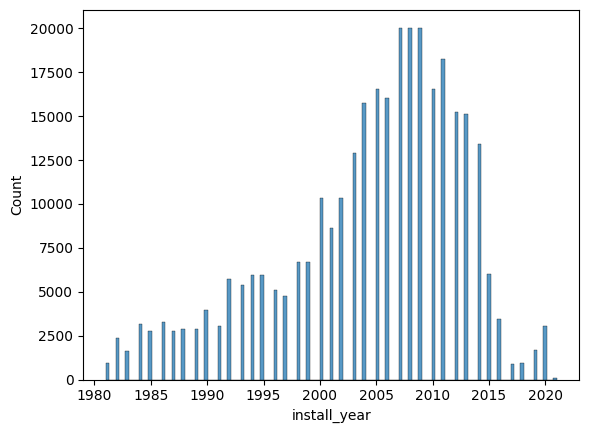

In [5]:
# sns.histplot(water['install_year']) # Includes years after 2021
water['install_year'] = np.where(water['install_year'] > 2021, np.nan, water['install_year'])

df = water[water['install_year'] > 1980]
sns.histplot(df['install_year'])

#### Creating a Map


In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

def get_points(df):
  return [Point(xy) for xy in zip(df['lon'], df['lat'])]

water_gdf = gpd.GeoDataFrame(water, geometry=get_points(water))

world = gpd.read_file(
  gpd.datasets.get_path('naturalearth_lowres')
)
africa = world.query('continent == "Africa"')

<AxesSubplot: >

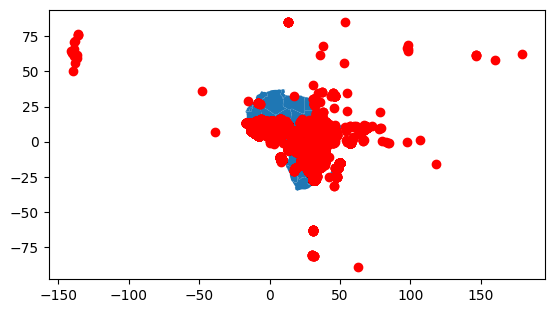

In [7]:
water_gdf.plot(ax=africa.plot(), marker = 'o', color='red')

A lot of erroneous points! Clearly there are some which lie outside the actual continent of Africa, but there could be others which are still within the continent but don't fall within the country for which they are coded. For that latter kind of point, it won't be clear whether the coordinates or the country name was entered incorrectly. 

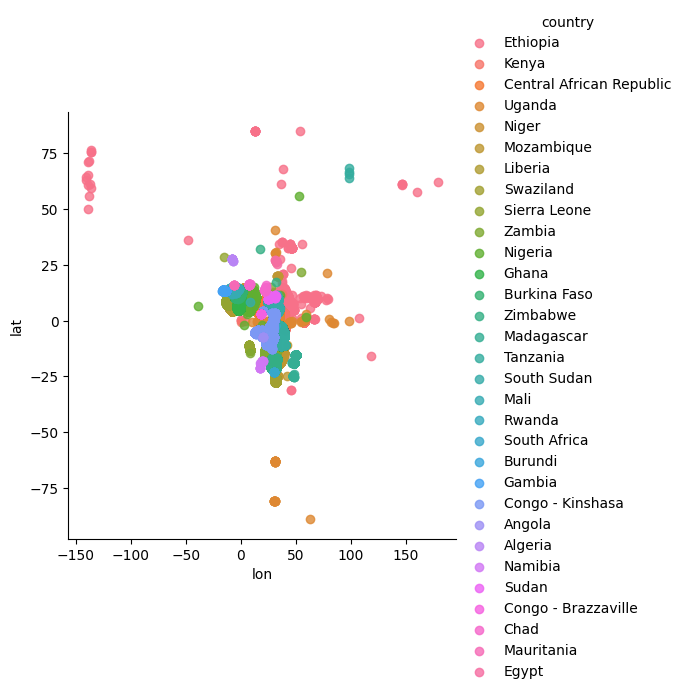

In [8]:
sns.lmplot(data=water_gdf, x='lon', y='lat', fit_reg=False, hue='country')

Hard to tell which countries the outlier points belong to based on subtle differences in hues. Plotting the country name next to each point for more than 400k points is also not going to make things clear! 


#### Solution Ideas: 

1. **_Approximate Solution_**:
We can calculate the mean of all the access points located within a country and then exclude points which lie outside a certain distance of that mean. 

1. **_More Precise Solution_**: We can load polygon geometries for each country and filter out access points associated with each country that lie outside its respective polyon. 

In [9]:
##  Plan #1: calculate mean latitude and longitude and use to exclude outliers  ##
df = water_gdf[['country', 'lat', 'lon']].groupby('country').mean()
df.reset_index(inplace=True)

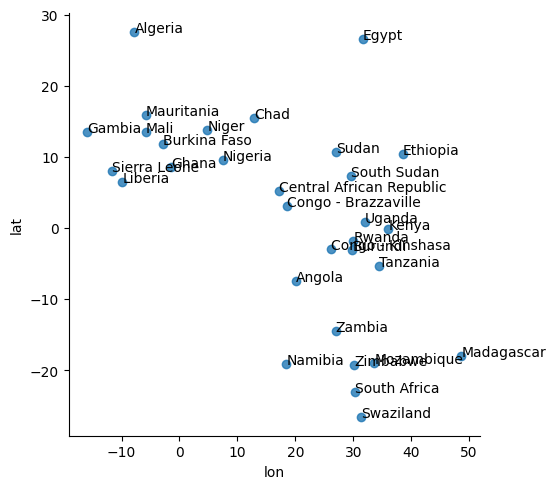

In [10]:
## Visualizing these means
import matplotlib.pyplot as plt

ax = sns.lmplot(x='lon', 
           y='lat', 
           data=df, 
           fit_reg=False)  

# Set x-axis label
plt.xlabel('lon')
# Set y-axis label
plt.ylabel('lat')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(df.lon, df.lat, df.country, plt.gca()) 
# Swaziland clearly has a significant amount of erroneous points (its mean latitude is below South Africa's!) 

In [11]:
## Converting these coordinates to point objects
centers = gpd.GeoDataFrame(df['country'], geometry=get_points(df)).set_index('country')
centers.rename({'geometry':'center'}, axis=1, inplace=True)
centers # not true country centers, as water access points in each country are not randomly distributed

,center
country,
Algeria,POINT (-7.77389 27.51296)
Angola,POINT (20.05520 -7.40231)
Burkina Faso,POINT (-2.83791 11.82479)
Burundi,POINT (29.83500 -3.15500)
Central African Republic,POINT (17.16059 5.14862)
Chad,POINT (12.94218 15.49871)
Congo - Brazzaville,POINT (18.53895 3.09209)
Congo - Kinshasa,POINT (26.20132 -2.98834)
Egypt,POINT (31.67089 26.60136)


In [12]:
## Joining centers to our geodataframe
water_gdf = water_gdf.merge(centers, how='left', left_on='country', right_index=True)
## Calculating distance of each point from center
water_gdf['distance'] = gpd.GeoSeries.distance(water_gdf['geometry'], water_gdf['center'])
## Identifying main culprits
distance_describe = water_gdf[['country', 'distance']].groupby('country').describe()['distance']
distance_describe.sort_values('max', ascending=False)
distance_describe

,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
Algeria,14.0,0.501890,3.499696e-01,0.205760,0.341949,0.356928,0.365173,1.147159
Angola,5.0,0.016133,7.489186e-03,0.008047,0.012488,0.014263,0.017947,0.027918
Burkina Faso,820.0,1.815065,1.010166e+00,0.121709,0.822091,1.802570,2.797462,4.307073
Burundi,2.0,0.304385,2.775558e-16,0.304385,0.304385,0.304385,0.304385,0.304385
Central African Republic,2447.0,1.759532,8.464113e-01,0.012377,1.390787,1.637367,2.120039,6.649100
Chad,35.0,6.831202,1.880844e+00,5.017734,5.494550,5.540527,8.989704,10.208435
Congo - Brazzaville,29.0,0.066283,3.409266e-02,0.024863,0.046285,0.048702,0.116866,0.125015
Congo - Kinshasa,7958.0,5.076633,3.007377e+00,0.274622,3.018819,4.100012,6.433628,13.448298
Egypt,8.0,0.384223,4.488250e-01,0.051979,0.104799,0.152640,0.574859,1.363414


We can set a general distance threshold to exclude outliers -- this is a decent "ballpark" solution for our plot. 

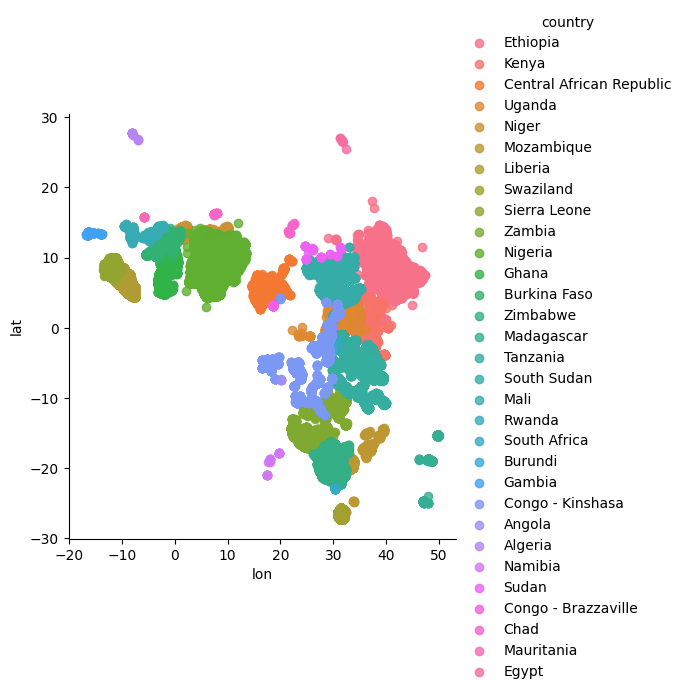

In [13]:
df = water_gdf[water_gdf['distance'] < 10] # Trial-and-error
sns.lmplot(data=df, x='lon', y='lat', fit_reg=False, hue='country')

##### Better Solution: 

In [14]:
# url = 'https://geoportal.icpac.net/geoserver/ows?service=WFS&version=1.0.0&request=GetFeature&typename=geonode%3Aafr_g2014_2013_0&outputFormat=json&srs=EPSG%3A4326&srsName=EPSG%3A4326'
# africa = gpd.read_file(url)

# from urllib.request import urlopen
# import json 

# response = urlopen(url)
# data_json = json.loads(response.read())

# with open ("./data/africa.json", "w") as outfile: 
#   json.dump(data_json, outfile)

In [16]:
with open ("./data/africa.json", "r") as geojson_file: 
  africa = gpd.read_file(geojson_file)

In [38]:
algeria = water_gdf[['country', 'geometry']][water_gdf['country'] == 'Algeria']

<bound method DataFrame.transpose of         country                   geometry
row_id                                    
471560  Algeria  POINT (-7.98361 27.46167)
471549  Algeria  POINT (-6.85923 26.84022)
471553  Algeria  POINT (-7.99566 27.77782)
471556  Algeria  POINT (-8.05107 27.73745)
471552  Algeria  POINT (-7.99544 27.77190)
471557  Algeria  POINT (-8.05861 27.73733)
471558  Algeria  POINT (-8.06123 27.73170)
471554  Algeria  POINT (-8.03385 27.75634)
471551  Algeria  POINT (-8.06731 27.73185)
471559  Algeria  POINT (-7.97434 27.46652)
471555  Algeria  POINT (-8.04424 27.74638)
471548  Algeria  POINT (-6.86278 26.82881)
471550  Algeria  POINT (-7.98714 27.77384)
471547  Algeria  POINT (-6.85996 26.81963)>

In [18]:
## Example of gpd.GeoSeries.contains
sudan_poly = africa.iloc[0,:][-1]
sudan_pts = water_gdf.loc[water_gdf['country'] == 'Sudan'][['geometry']]

sudan_poly.contains(sudan_pts)

,geometry
row_id,
471660,True
471670,False
471675,False
471665,True
471655,True
471687,True
471666,True
471683,True
471662,True


In [ ]:
from urllib.request import urlopen
import json 

response = urlopen(url)
data_json = json.loads(response.read())

with open ("./data/africa.json", "w") as outfile: 
  json.dump(data_json, outfile)